In [12]:
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import Workbook
from openpyxl import load_workbook
import time
import datetime
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import datetime
import dateutil
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
from scipy import integrate
import math

In [13]:
timepoints = np.linspace(0,50,1000,dtype='f')

In [14]:
### All units in M for concentrations, s^-1 for kinetic parameters
    ### Fv is the volume fraction of the capsid, nA is avogadro's number
    ### Km and kcat are for the PhoA-GN enzyme

nA = 6.022*10**23
Fv = 1*10**-7
kcat = 31.4  
Km  = 2.45*10**-6

In [15]:
### The k1 and k2 values for the T71E capsid. Ki is also for the PhoA-Gn enzyme

k1 = 1.02*10**4
k2 = 6.08*10**2
Ki = 2.67 *10**-6

In [16]:
### Range of substrate concentrations

S0range = np.geomspace(0.1,50,num=8,dtype='f') * 10**-6
Sc0 = 0.0
Pc0 = 0.0
Ic0 = 0.0

In [17]:
resultsdict = {}

In [18]:
for concentration in S0range:
    
    S0 = concentration
    Sc0 = 0.0
    P0 = 0.0
    I0 = 0.0
    y0 = [S0,Sc0,P0,I0]
    
 ### the 't' prefix on these kinetic parameters indicates that they've been temporarily adjusted for incorporation into the model.   
    tkcat = kcat/nA ### kcat here is adjusted by nA so that the integration doesn't immediately break
    tk2 = k2 ### I've used temporary k1/2 here for manually playing around with the magnitude, though this example code uses the regular k1/2
    tk1 = k1
    
    def nanoreactor_wt_kmapp(y,t):
        
        S,Sc,P,I = y
        dpdt = (tkcat*Sc)/(Km+((Km*I)/Ki)+Sc)
        dsdt = 0
        dscdt = (tk1*(S - Sc)) - (dpdt/Fv)
        didt = (dpdt/Fv) - (tk2*I)
        
        dydt = [dsdt,dscdt,dpdt,didt]
        return dydt
    
    conctitle = round(concentration*10**6,2)
    resultsdict[conctitle] = scipy.integrate.odeint(nanoreactor_wt_kmapp,y0,timepoints)
    


In [19]:
wt_kmapp_timecourse = resultsdict

wt_kmapp_slopes = {}

for key,value in wt_kmapp_timecourse.items():
    wt_kmapp_slopes[key] = scipy.stats.linregress(timepoints,value[:,2]).slope
    
wt_kmapp_slopes #slopes of product formation for 1 enzyme at various S concenctrations

{0.1: 2.044790017705463e-24,
 0.24: 4.704605453447172e-24,
 0.59: 1.0124994398570951e-23,
 1.43: 1.925550233026401e-23,
 3.49: 3.061950097899267e-23,
 8.47: 4.0442589680489737e-23,
 20.58: 4.659462324455593e-23,
 50.0: 4.970652556740977e-23}

In [20]:
wt_kmapp_preframe = {}

for key, value in wt_kmapp_timecourse.items():
    wt_kmapp_preframe[key] = pd.DataFrame(value,index=timepoints,columns=['S','Sc','P','I'])
    
wt_kmapp_frame = pd.concat(wt_kmapp_preframe)
index = pd.MultiIndex.from_tuples(wt_kmapp_frame.index.values,names = ['Conc','Time'])
wt_kmapp_frame.index = index

(Text(0.5, 1.0, 'S'),
 Text(0.5, 1.0, 'Sc'),
 Text(0.5, 1.0, 'P'),
 Text(0.5, 1.0, 'I'))

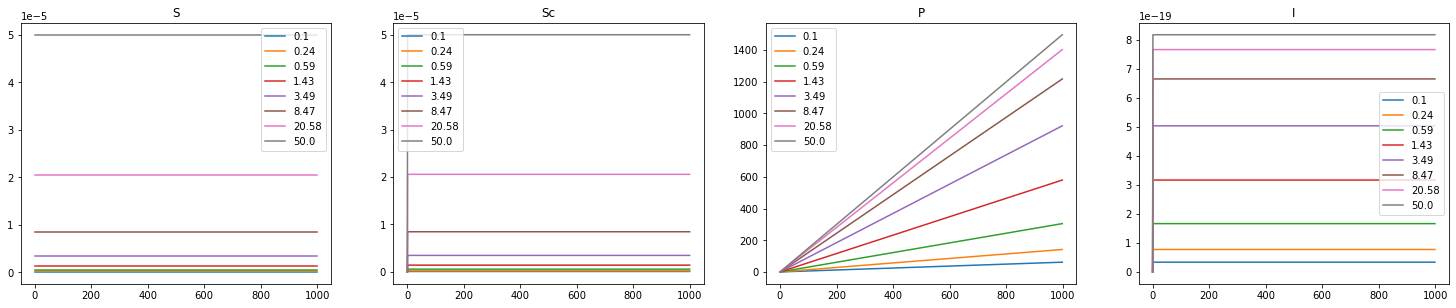

In [21]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25.6,4.8))

for key,frame in wt_kmapp_frame.groupby('Conc',axis='index'):
    ax1.plot(frame['S'].values,label = key),ax2.plot(frame['Sc'].values,label = key),ax3.plot(frame['P'].values*nA,label = key),ax4.plot(frame['I'].values,label = key) 
    ### Note that for display purposes I've multiplied the product concentration by nA so that it show the M of product/M enzyme
    
ax1.legend(),ax2.legend(),ax3.legend(),ax4.legend()
ax1.set_title('S'),ax2.set_title('Sc'),ax3.set_title('P'),ax4.set_title('I')

In [ ]:
### Current issues:
    ### - I don't know what the scale of the inhibitor concentration is and how to appropriately scale it. It adopts a steady state like in figure S7 in the SI but the actual value is off
    ### - When I play around with the k1 and k2 manually the rate of P formation doesn't change unless the k1/2 is changed enough that Sc or I are no longer in a steady state
    ### - Really what I'm wondering now is what exactly I should be looking at/comparing to to make sure I'm doing things right. 
            ### - Are the figures in S7 representing the simulated data for the enzyme encapsulated in T71E capsid?
            ### - If so I'm currently off because the rate of P formation matches that of the Wt capsid - which makes me think something is off with the diffusivity parameters
                ###, as they don't really change the kinetics
            ### - If there is something wrong with the model, is it something to do with how the numbers have been set, or is it something to do with how the code is executed?

In [ ]:
### To further illustrate my point of confusion I've included simulated data with a model that doesn't incorporate substrate diffusion
###      The initial rates of P formation are the same as above, and so the apparent kcat and Km hasn't changed when substrate/product transport is included in the model.
###      The only thing that has changed is that the I doesn't adopt a steady state concentration (makes sense because it isn't being removed from the system)

In [30]:
resultsdict = {}

In [31]:
for concentration in S0range:
    
    S0 = concentration
    Sc0 = 0.0
    P0 = 0.0
    I0 = 0.0
    y0 = [S0,P0,I0]
    
 ### the 't' prefix on these kinetic parameters indicates that they've been temporarily adjusted for incorporation into the model.   
    tkcat = kcat/nA ### kcat here is adjusted by nA so that the integration doesn't immediately break
    tk2 = k2 ### I've used temporary k1/2 here for manually playing around with the magnitude, though this example code uses the regular k1/2
    tk1 = k1
    
    def nanoreactor_no_diff(y,t):
        
        S,P,I = y
        dpdt = (tkcat*S)/(Km+((Km*I)/Ki)+S)
        dsdt = 0
        
        didt = dpdt
        
        dydt = [dsdt,dpdt,didt]
        return dydt
    
    conctitle = round(concentration*10**6,2)
    resultsdict[conctitle] = scipy.integrate.odeint(nanoreactor_no_diff,y0,timepoints)
    


In [32]:
no_diff_timecourse = resultsdict

no_diff_slopes = {}

for key,value in no_diff_timecourse.items():
    no_diff_slopes[key] = scipy.stats.linregress(timepoints,value[:,2]).slope
    
no_diff_slopes #slopes of product formation for 1 enzyme at various S concenctrations

{0.1: 2.044790041257449e-24,
 0.24: 4.704605506228744e-24,
 0.59: 1.0124994505545009e-23,
 1.43: 1.925550250867091e-23,
 3.49: 3.061950120239096e-23,
 8.47: 4.0442589880763435e-23,
 20.58: 4.659462338416937e-23,
 50.0: 4.9706525648325516e-23}

In [34]:
no_diff_preframe = {}

for key, value in no_diff_timecourse.items():
    no_diff_preframe[key] = pd.DataFrame(value,index=timepoints,columns=['S','P','I'])
    
no_diff_frame = pd.concat(no_diff_preframe)
index = pd.MultiIndex.from_tuples(no_diff_frame.index.values,names = ['Conc','Time'])
no_diff_frame.index = index

(Text(0.5, 1.0, 'S'), Text(0.5, 1.0, 'P'), Text(0.5, 1.0, 'I'))

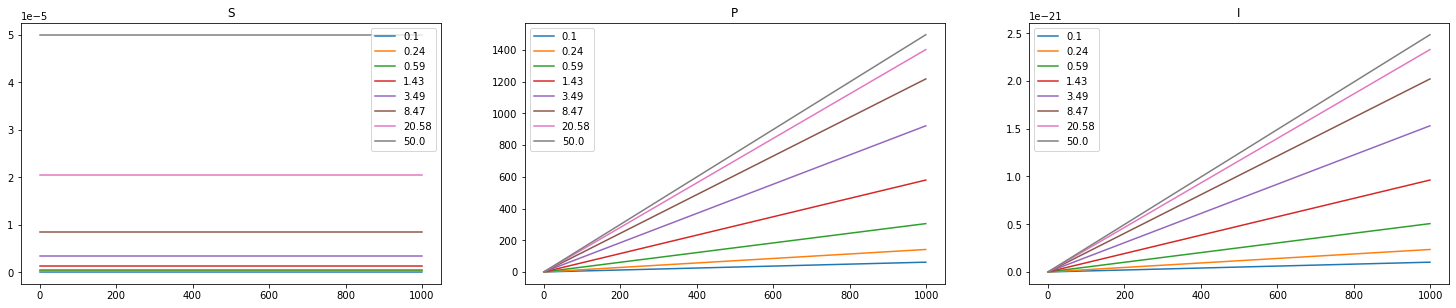

In [36]:
fig,(ax1,ax3,ax4) = plt.subplots(1,3,figsize=(25.6,4.8))

for key,frame in no_diff_frame.groupby('Conc',axis='index'):
    ax1.plot(frame['S'].values,label = key),ax3.plot(frame['P'].values*nA,label = key),ax4.plot(frame['I'].values,label = key) 
    ### Note that for display purposes I've multiplied the product concentration by nA so that it show the M of product/M enzyme
    
ax1.legend(),ax3.legend(),ax4.legend()
ax1.set_title('S'),ax3.set_title('P'),ax4.set_title('I')